In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydaddy
from scipy.signal import correlate
from scipy.optimize import curve_fit
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance
import sdeint

In [2]:
def acf(data, t_lag=1000):
    """
    Calculates autocorrelation using wiener khinchin theorem.
    """

    data = data - data.mean()
    x = np.arange(0, t_lag)
    c = np.fft.ifft(np.square(np.abs(np.fft.fft(data))))
    c /= c[0]
    return c[0:t_lag]

def act(m):
    rho = acf(m)
    rho = rho[rho.argmax():]
    t = np.arange(rho.size)
    ftau = lambda t, a, b, c: a * np.exp((-t / b)) + c
    params, cov = curve_fit(ftau, t, rho)
    tau = params[1]
    return tau

def trel(m1, m2):
    tau1, tau2 = act(m1), act(m2)
    print(f'tau_1: {tau1}')
    print(f'tau_2: {tau2}')    
    
    print(f'T_rel: {abs(tau1 - tau2)/ tau1}')

In [3]:
def simulate(F1, F2, G11, G22, t_int, timepoints, x0=None):
    tspan = np.arange(0, t_int * timepoints, step=t_int)
    
    def F(x):
        return np.array([F1(*x), F2(*x)])

    def G(x):
            return np.diag([np.sqrt(np.abs(G11(*x))), np.sqrt(np.abs(G22(*x)))])

    if x0 is None:
        x0 = np.array([0., 0.])

    x_sim = np.zeros((timepoints, 2))
    x_sim[0, :] = x0
    
    for i in range(1, timepoints):
        x_next = (x_sim[i - 1, :] + 
                  t_int * F(x_sim[i - 1, :]) + 
                  np.sqrt(t_int) * G(x_sim[i - 1, :]) @ np.random.normal(size=(2, )))
        while(x_next[0] ** 2 + x_next[1] ** 2 > 1):
            x_next = (x_sim[i - 1, :] + 
                  t_int * F(x_sim[i - 1, :]) + 
                  np.sqrt(t_int) * G(x_sim[i - 1, :]) @ np.random.normal(size=(2, )))
        x_sim[i, :] = x_next
        
    return x_sim

In [20]:
dataset = '30'
f_act = f'data/{dataset}_extracted.npy'
f_sim = f'data/sampled_x_0_bc_{dataset}.npy'

actual = np.load(f_act)
simulated = np.load(f_sim)

modm_actual = np.sqrt(actual[:, 0] ** 2 + actual[:, 1] ** 2)
modm_simulated = np.sqrt(simulated[:, 0] ** 2 + simulated[:, 1] ** 2)

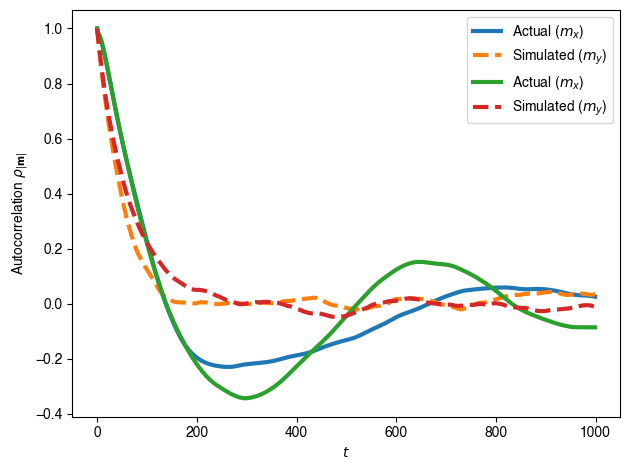

In [21]:
acf_x_actual = acf(actual[:, 0])
acf_x_simulated = acf(simulated[:, 0])
acf_y_actual = acf(actual[:, 1])
acf_y_simulated = acf(simulated[:, 1])
# acf_simulated_pyd = acf(modm_simulated_pyd)

# plt.figure(figsize=(8, 8))
plt.plot(acf_x_actual[:2000], lw=3, label='Actual ($m_x$)')
plt.plot(acf_x_simulated[:2000], '--', lw=3, label='Simulated ($m_y$)')

plt.plot(acf_y_actual[:2000], lw=3, label='Actual ($m_x$)')
plt.plot(acf_y_simulated[:2000], '--', lw=3, label='Simulated ($m_y$)')

plt.xlabel('$t$')
plt.ylabel('Autocorrelation $\\rho_{|\\mathbf{m}|}$')
plt.legend()
plt.tight_layout()
# plt.savefig(f'{dataset}_autocorr.pdf')
plt.show()